In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu

In [3]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1000000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [4]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:

exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [53]:
df_gene_chr = pd.DataFrame(list(zip([x[3].decode() for x in jac_exp.cut_intervals], [x[0] for x in jac_exp.cut_intervals])),
               columns =['gene', 'chrom'])

In [54]:
df_gene_chr['val'] = 1

In [56]:
jac_exp.cut_intervals

[('chr1', 0, 1, b'ENSG00000278267'),
 ('chr1', 0, 1, b'ENSG00000233750'),
 ('chr1', 0, 1, b'ENSG00000268903'),
 ('chr1', 0, 1, b'ENSG00000269981'),
 ('chr1', 0, 1, b'ENSG00000241860'),
 ('chr1', 0, 1, b'ENSG00000279928'),
 ('chr1', 0, 1, b'ENSG00000279457'),
 ('chr1', 0, 1, b'ENSG00000228463'),
 ('chr1', 0, 1, b'ENSG00000237094'),
 ('chr1', 0, 1, b'ENSG00000225972'),
 ('chr1', 0, 1, b'ENSG00000225630'),
 ('chr1', 0, 1, b'ENSG00000237973'),
 ('chr1', 0, 1, b'ENSG00000229344'),
 ('chr1', 0, 1, b'ENSG00000240409'),
 ('chr1', 0, 1, b'ENSG00000248527'),
 ('chr1', 0, 1, b'ENSG00000198744'),
 ('chr1', 0, 1, b'ENSG00000228327'),
 ('chr1', 0, 1, b'ENSG00000237491'),
 ('chr1', 0, 1, b'ENSG00000230092'),
 ('chr1', 0, 1, b'ENSG00000177757'),
 ('chr1', 0, 1, b'ENSG00000228794'),
 ('chr1', 0, 1, b'ENSG00000225880'),
 ('chr1', 0, 1, b'ENSG00000230699'),
 ('chr1', 0, 1, b'ENSG00000223764'),
 ('chr1', 0, 1, b'ENSG00000187634'),
 ('chr1', 0, 1, b'ENSG00000188976'),
 ('chr1', 0, 1, b'ENSG00000187961'),
 

In [52]:
df_gene_chr = df_gene_chr.pivot_table(index='gene', columns='chrom', values='val', aggfunc='sum')

In [15]:
df_gene_chr = df_gene_chr.fillna(0)

In [17]:
df_2d_jac, go_chrom  = run_egad(df_gene_chr, df_exp_corr)

(24243, 24243)
(24243, 23)
0.9565217391304348
0.0


In [41]:
resolution_human = 10000
species = "human"
SRP_name = "aggregates"
resolution = "10kbp_raw"

In [42]:
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])

In [45]:
bins_bed

chr     start       end  bin_id
0        chr1         0     10000       1
1        chr1     10000     20000       1
2        chr1     20000     30000       1
3        chr1     30000     40000       1
4        chr1     40000     50000       1
...       ...       ...       ...     ...
287504  chr22  50770000  50780000       1
287505  chr22  50780000  50790000       1
287506  chr22  50790000  50800000       1
287507  chr22  50800000  50810000       1
287508  chr22  50810000  50818468       1

[287509 rows x 4 columns]

In [46]:
df_auc_vs_size = bins_bed.groupby(['chr'])['bin_id'].sum().reset_index().merge(df_2d_jac, left_on='chr', right_on=df_2d_jac.index)


In [47]:
%matplotlib inline
import seaborn as sns

<AxesSubplot:xlabel='bin_id', ylabel='AUC'>

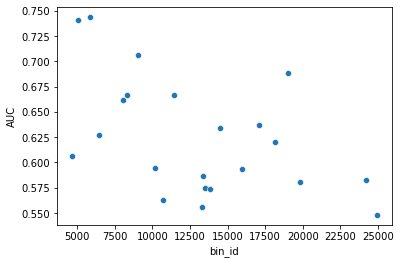

In [57]:
sns.scatterplot(x=df_auc_vs_size['bin_id'], y=df_auc_vs_size['AUC'])

In [58]:
df_auc_vs_size['AUC'].mean()

0.625168691796963

<AxesSubplot:xlabel='AUC', ylabel='Count'>

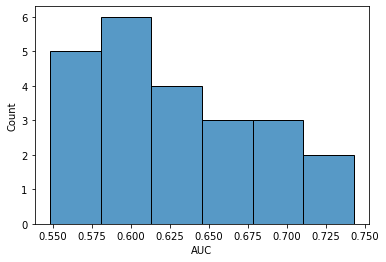

In [38]:
sns.histplot(df_auc_vs_size['AUC'])

In [40]:
df_auc_vs_size['AUC'].median()

0.6205655018097177

In [ ]:
df_gene_chr

In [18]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC        P_Value
chrom                                                           
chr1   0.548086     12339.842509         0.500163   1.654169e-16
chr10  0.586479     12438.598510         0.509500   1.143218e-20
chr11  0.574297     12373.596395         0.504759   1.818544e-20
chr12  0.556375     12376.406448         0.504662   8.466436e-13
chr13  0.667056     12156.259454         0.491709   1.109736e-36
chr14  0.562514     12193.342382         0.497277   7.912834e-10
chr15  0.594549     12143.086516         0.487864   1.052527e-21
chr16  0.706183     12335.161854         0.499546  8.773301e-126
chr17  0.666923     12595.475912         0.516480  1.190610e-102
chr18  0.662012     11630.005105         0.458888   1.417273e-29
chr19  0.743358     12796.638458         0.529496  5.206787e-237
chr2   0.583047     12288.538649         0.501277   2.970102e-31
chr20  0.626716     12350.859676         0.506664   2.054682e-29
chr21  0.606783     11578.942705         0.451534   5.082539e-10
chr22  0.740890     12264.462411         0.493158   1.192274e-92
chr3   0.580678     12552.541917         0.518726   4.347483e-25
chr4   0.688013     12121.824832         0.487091   3.659621e-87
chr5   0.620566     11982.817831         0.479412   4.853560e-45
chr6   0.636830     11747.767883         0.467278   4.285290e-56
chr7   0.593755     12443.340673         0.507129   4.118314e-29
chr8   0.634348     11803.715731         0.465617   4.540686e-41
chr9   0.574253     12519.524911         0.513562   2.091948e-15
chrX   0.693078     12553.542469         0.513710   5.165830e-77

In [6]:
%matplotlib inline
import seaborn as sns

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


KeyboardInterrupt: 

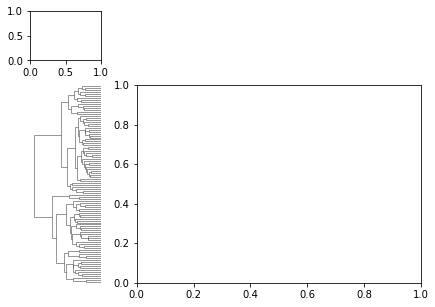

In [7]:
sns.clustermap(
    df_exp_corr.head(100),
    figsize=(7, 5),


)

<AxesSubplot:>

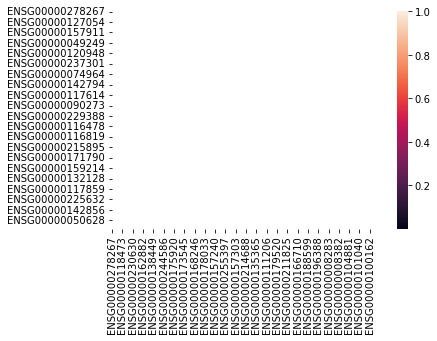

In [10]:
sns.heatmap(df_exp_corr.head(1000))

In [ ]:
plt.imshow(df_exp_corr.head(1000), cmap='hot')

In [11]:
import matplotlib.pyplot as plt

In [ ]:
plt.savefig('test.png', dpi=600)

In [ ]:
plt.savefig('test.png', dpi=600)


In [59]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path

In [ ]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_ranked_inter.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]